## Import libraries

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

## Define score list

In [45]:
# score list (modelName, scalerName, parameters, score)
score_list = []

## Function - load_and_modification_dataset()

In [46]:
# =====================================================================
# Function Name : load_and_modification_dataset
# Function Description : Loads and modifies the dataset.
# Input : 
    # fileName = dataset fileName (including Path, if you need)
# Output : Show Data Exploration(original, modified), return Modified dataset
# =====================================================================

def load_and_modification_dataset(fileName):

    # Load dataset
    df = pd.read_csv(fileName)

    # Data Exploration -----------------------------------

    print('='*27,'<Original Dataset>','='*27)
    print(df.info(), end='\n\n')
    display(df)

    # Data Preprocessing ---------------------------------

    # Drop ID columns
    df = df.drop(['ID'], axis=1)

    # Clean the dirty data in Bare Nuclei using mean
    df['Bare Muclei'].value_counts()
    df['Bare Muclei'] = df['Bare Muclei'].replace("?", "")
    df['Bare Muclei'] = pd.to_numeric(df['Bare Muclei'])
    df['Bare Muclei'] = df['Bare Muclei'].fillna(df['Bare Muclei'].mean())

    # get correlations of pairs of features in the dataset
    corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))

    # plot the heatmap
    g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")
    plt.show()
    plt.clf()

    # Drop the Mitoses feature because lower correlation with target feature
    df = df.drop(['Mitoses'], axis=1)

    # Modified Dataset
    modified_df = df

    # Plot dataset
    for feature in modified_df.columns.values:
        group_df = modified_df.groupby([feature], dropna=False, as_index=False)
        plt.clf()
        plt.pie(group_df.size()['size'], labels=group_df.size()[
                feature].unique(), autopct="%1.2f%%")
        plt.title("Pie chart ("+feature+")")
        plt.show()
        print(group_df.size(), end="\n\n")
    
    # Check modified dataset
    print('='*27,'<Modified Dataset>','='*27)
    print(df.info(), end='\n\n')
    display(df)

    # Return modified dataset
    return modified_df

## Function - scaling()

In [47]:
# =====================================================================
# Function Name : scaling
# Function Description : Scale the input dataset
# Input : 
    # dataset = modified_df for scaling
    # method = scaling method (minmax, standard, None)
# Output : plotting(before, after), return scaled_df
# =====================================================================

def scaling(dataset, method='None'):

    # drop label columns
    dataset_X = dataset.drop(['Class'], axis=1)

    # Select Scaling method
    if method=="minmax":
        scaler = preprocessing.MinMaxScaler()
    elif method=="standard":
        scaler = preprocessing.StandardScaler()
    elif method=='None':
        return dataset

    # Fit & Transform
    scaled_df = scaler.fit_transform(dataset_X)
    scaled_df = pd.DataFrame(scaled_df,columns=dataset_X.columns)

    # Make subplot
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(7,5))

    # Before Scaling plot
    ax1.set_title("Before Scaling")
    ax1.set_xlabel("values")
    for feature in dataset_X.columns.values:
        sns.kdeplot(dataset_X[feature], ax=ax1)

    # After Scaling plot
    ax2.set_title("After Scaling("+method+")")
    ax2.set_xlabel("values")
    for feature in scaled_df.columns.values:
        sns.kdeplot(scaled_df[feature], ax=ax2)
    plt.show()

    # Attach label columns
    scaled_df = pd.concat([scaled_df,dataset['Class']],axis=1)

    # Return scaled_df
    return scaled_df

## Function - modeling_testing()

In [48]:
# =====================================================================
# Function Name : modeling_testing
# Function Description : Get the model and parameters and proceed with modeling, print cross validation score.
# Input : 
    # scaled_df = Dataset with scaling completed
    # scalerName = The name of the scaling function
    # modelName = The name of the model you want to use
    # model_params = Parameters values used in each model
    # test_size = Specifying the size of the testset when performing data split (default = 0.3)
# Output : Output of evaluation scores with Cross Validation & result plotting.
# =====================================================================

def modeling_testing(scaled_df, scalerName, modelName, model_params, test_size=0.3):

    # X,y
    X = scaled_df.iloc[:,:-1]
    y = scaled_df.iloc[:,-1]

    # Split train/test
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=42)

    # =====================================================================
    # Modeling (DT_entropy)
    if modelName=='DT_entropy':

        # max_features = ['auto','sqrt','log2']
        for max_features in list(list(list(model_params.values())[0].values())[1]):

            # DT (entropy)
            model = DecisionTreeClassifier(criterion='entropy')
            model.fit(X_train, y_train)
            y_pred_tr = model.predict(X_test)

            print('='*70)
            print("Predict accuracy (using X_test, y_test)-->%.5f"
             % accuracy_score(y_test,y_pred_tr))

            # Plotting DT(entropy)
            plt.figure()
            plot_tree(model,filled=True)
            plt.title("Decision Tree (entropy)")
            plt.show()

            # Testing
            print('='*27,'<','Cross Validation','>','='*27)
            for k in [5,7,9]:

                # KFold
                kf = KFold(n_splits=k)
                score = cross_val_score(model,X,y,cv=kf)

                # Show result
                print('Average CV score({}): {}'.format(
                    'model='+modelName+
                    ' , scaler='+scalerName+' , max_features='+max_features+
                    ' , CV='+str(k), score.mean()))
                # Save result
                score_list.append(['model='+modelName+' , scaler='+scalerName+
                ' , max_features='+max_features+' , CV='+str(k), score.mean()])
            print()

    # =====================================================================
    # Modeling (DT_gini)
    elif modelName=='DT_gini':

        # max_features = ['auto','sqrt','log2']
        for max_features in list(list(list(model_params.values())[0].values())[1]):

            # DT (gini)
            model = DecisionTreeClassifier(criterion='gini')
            model.fit(X_train, y_train)
            y_pred_tr = model.predict(X_test)

            print('='*70)
            print("Predict accuracy (using X_test, y_test)-->%.5f"
             % accuracy_score(y_test,y_pred_tr))

            # Plotting DT(gini)
            plt.figure()
            plot_tree(model,filled=True)
            plt.title("Decision Tree (gini)")
            plt.show()

            # Testing
            print('='*27,'<','Cross Validation','>','='*27)
            for k in [5,7,9]:

                # KFold
                kf = KFold(n_splits=k)
                score = cross_val_score(model,X,y,cv=kf)

                # Show result
                print('Average CV score({}): {}'.format(
                    'model='+modelName+
                    ' , scaler='+scalerName+' , max_features='+max_features+
                    ' , CV='+str(k), score.mean()))
                
                # Save result
                score_list.append(['model='+modelName+' , scaler='+scalerName+
                ' , max_features='+max_features+' , CV='+str(k), score.mean()])
            print()

    # =====================================================================
    # Modeling (SVM)
    elif modelName=='SVM':

        # kernel = ['linear','poly','rbf','sigmoid']
        for kernel in list(list(list(model_params.values())[2].values())[0]):

            # gamma = ['scale','auto']
            for gamma in list(list(list(model_params.values())[2].values())[1]):

                # C = ['0.01','0.1','1']
                for C in list(list(list(model_params.values())[2].values())[2]):

                    # SVM (SVC)
                    model = SVC(kernel=kernel, gamma=gamma, C=C)
                    model.fit(X_train, y_train)
                    y_pred_tr = model.predict(X_test)

                    print('='*70)
                    print("Predict accuracy (using X_test, y_test)-->%.5f"
                     % accuracy_score(y_test,y_pred_tr))

                    # Testing
                    print('='*27,'<','Cross Validation','>','='*27)
                    for k in [5,7,9]:

                        # KFold
                        kf = KFold(n_splits=k)
                        score = cross_val_score(model,X,y,cv=kf)

                        # Show result
                        print('Average CV score({}): {}'.format(
                            'model='+modelName+
                            ' , scaler='+scalerName+' , kernel='+kernel+
                            ' , gamma='+str(gamma)+' , C='+str(C)+
                            ' , CV='+str(k), score.mean()))
                        
                        # Save result
                        score_list.append(['model='+modelName+' , scaler='+scalerName+
                        ' , kernel='+kernel+' , gamma='+str(gamma)+' , C='+str(C)+
                        ' , CV='+str(k), score.mean()])
                    print()
                    
    # =====================================================================
    # Modeling (ligistic regression)
    elif modelName=='logistic_regression':

        # solver = ['newton-cg','lbfgs','liblinear','sag','saga']
        for solver in list(list(list(model_params.values())[3].values())[0]):

            # LogisticRegression
            model = LogisticRegression(solver=solver)
            model.fit(X_train, y_train)
            y_pred_tr = model.predict(X_test)
            print('='*70)
            print("Predict accuracy (using X_test, y_test)-->%.5f"
             % accuracy_score(y_test,y_pred_tr))

            # Testing
            print('='*27,'<','Cross Validation','>','='*27)
            for k in [5,7,9]:

                # KFold
                kf = KFold(n_splits=k)
                score = cross_val_score(model,X,y,cv=kf)

                # Show result
                print('Average CV score({}): {}'.format(
                    'model='+modelName+
                    ' , scaler='+scalerName+' , solver='+solver+
                    ' , CV='+str(k), score.mean()))
                
                # Save result
                score_list.append(['model='+modelName+' , scaler='+scalerName+
                ' , solver='+solver+' , CV='+str(k), score.mean()])
            print()

## Function - do_classification()

In [49]:
# =====================================================================
# Function Name : do_classification
# Function Description : Proceed whole process
# Input : -None-
# Output : return top_5 classification methods and scores
# =====================================================================

def do_classification():

    # load and modification dataset
    modified_df = load_and_modification_dataset('breast-cancer-wisconsin.csv')

    # Scaling
    for scalerName in ['minmax','standard','None']:
        print('='*27,'< Scaler name :',scalerName,'>','='*27, end='\n\n')
        scaled_df = scaling(modified_df, scalerName)

        # Model Parameters
        model_params={
            'DT_entropy': {
                'criterion':'entropy', 'max_features':['auto','sqrt','log2']
            },
            'DT_gini': {
                'criterion':'gini','max_features':['auto','sqrt','log2']
            },
            'SVM': {
                'kernel':['linear','poly','rbf','sigmoid'],
                'gamma':[0.001,0.01,0.1,1,10],
                'C':[0.01,0.1,1]
            },
            'logistic_regression': {
                'solver':['newton-cg','lbfgs','liblinear','sag','saga']
            }
        } 

        # Modeling & Testing
        for modelName in ['DT_entropy','DT_gini','SVM','logistic_regression']:
            print('='*27,'< Model name :',modelName,'>','='*27, end='\n\n')
            modeling_testing(scaled_df, scalerName, modelName, model_params, 0.3)

    # Find top_5 scores (with modelName, params, etc)
    score_list.sort(key=lambda x : x[-1], reverse=True)
    top_5 = score_list[:5]

    # Check whole scores
    # for scores in score_list:
    #     print(scores)
    # print()

    # Return top_5
    return top_5

## Main Code

=========================== <Original Dataset> ===========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ID                     699 non-null    int64 
 1   Thickness              699 non-null    int64 
 2   Uniformity Cell Size   699 non-null    int64 
 3   Uniformity Cell Shape  699 non-null    int64 
 4   Adhesion               699 non-null    int64 
 5   Single Cell Size       699 non-null    int64 
 6   Bare Muclei            699 non-null    object
 7   Chromatin              699 non-null    int64 
 8   Normal Nucleoli        699 non-null    int64 
 9   Mitoses                699 non-null    int64 
 10  Class                  699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB
None



,ID,Thickness,Uniformity Cell Size,Uniformity Cell Shape,Adhesion,Single Cell Size,Bare Muclei,Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


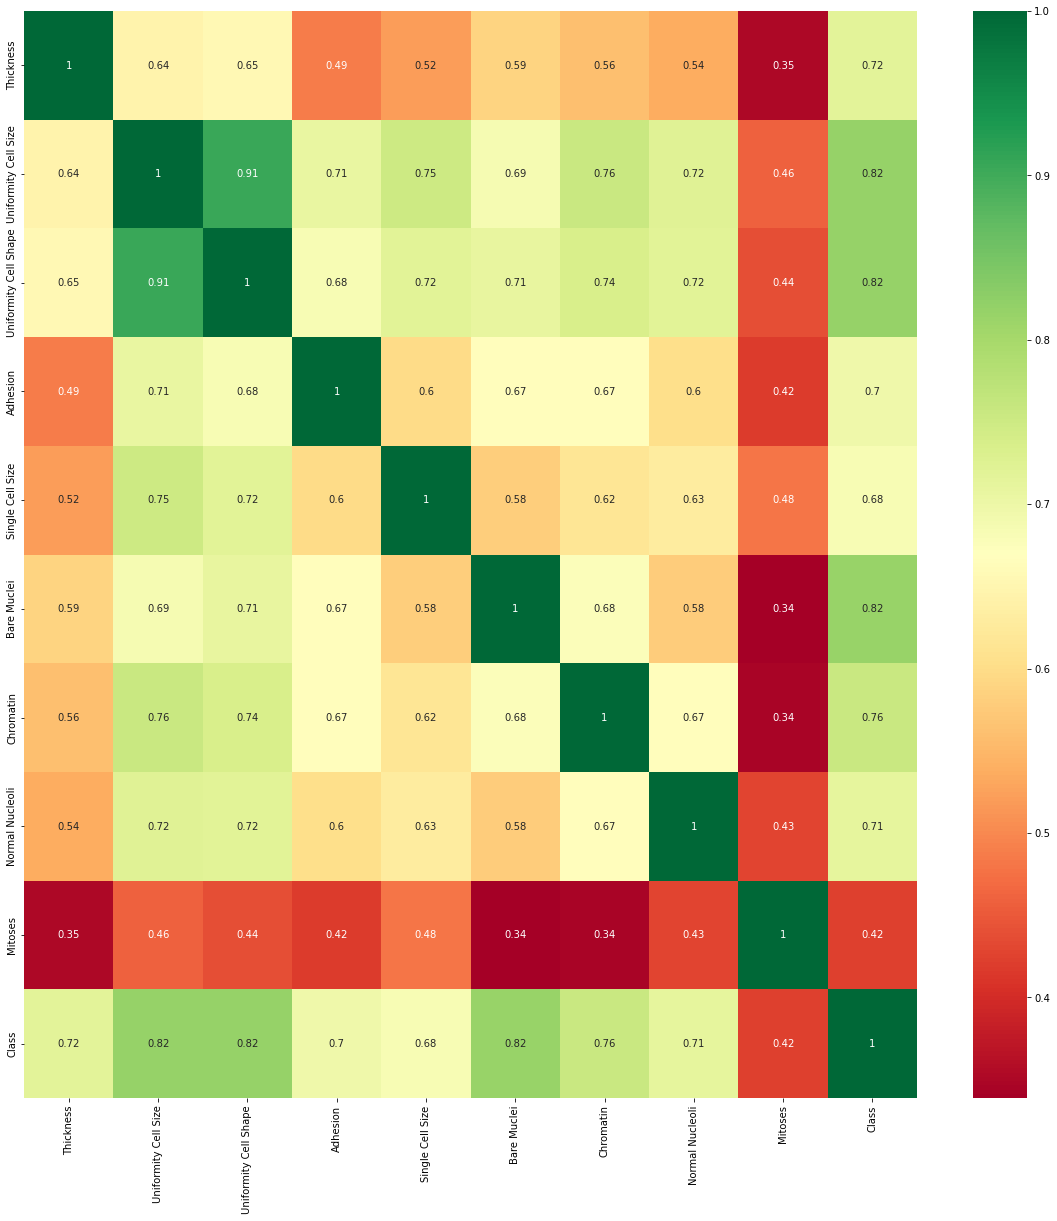

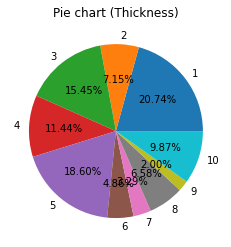

   Thickness  size
0          1   145
1          2    50
2          3   108
3          4    80
4          5   130
5          6    34
6          7    23
7          8    46
8          9    14
9         10    69



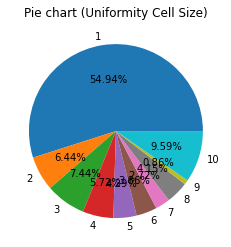

   Uniformity Cell Size  size
0                     1   384
1                     2    45
2                     3    52
3                     4    40
4                     5    30
5                     6    27
6                     7    19
7                     8    29
8                     9     6
9                    10    67



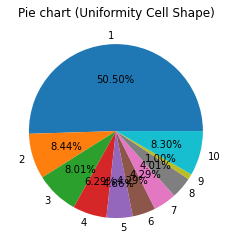

   Uniformity Cell Shape  size
0                      1   353
1                      2    59
2                      3    56
3                      4    44
4                      5    34
5                      6    30
6                      7    30
7                      8    28
8                      9     7
9                     10    58



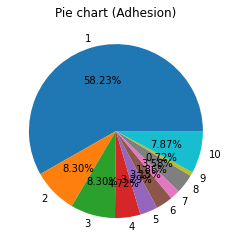

   Adhesion  size
0         1   407
1         2    58
2         3    58
3         4    33
4         5    23
5         6    22
6         7    13
7         8    25
8         9     5
9        10    55



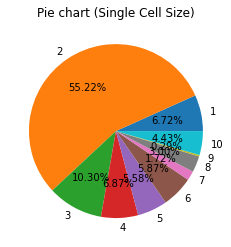

   Single Cell Size  size
0                 1    47
1                 2   386
2                 3    72
3                 4    48
4                 5    39
5                 6    41
6                 7    12
7                 8    21
8                 9     2
9                10    31



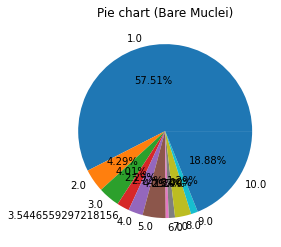

    Bare Muclei  size
0      1.000000   402
1      2.000000    30
2      3.000000    28
3      3.544656    16
4      4.000000    19
5      5.000000    30
6      6.000000     4
7      7.000000     8
8      8.000000    21
9      9.000000     9
10    10.000000   132



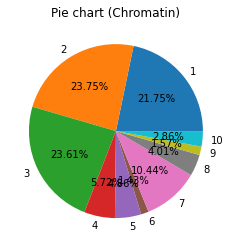

   Chromatin  size
0          1   152
1          2   166
2          3   165
3          4    40
4          5    34
5          6    10
6          7    73
7          8    28
8          9    11
9         10    20



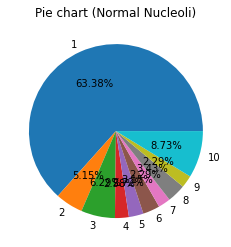

   Normal Nucleoli  size
0                1   443
1                2    36
2                3    44
3                4    18
4                5    19
5                6    22
6                7    16
7                8    24
8                9    16
9               10    61



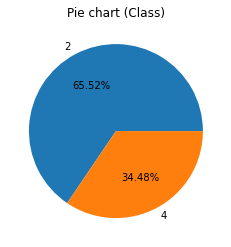

   Class  size
0      2   458
1      4   241

=========================== <Modified Dataset> ===========================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Thickness              699 non-null    int64  
 1   Uniformity Cell Size   699 non-null    int64  
 2   Uniformity Cell Shape  699 non-null    int64  
 3   Adhesion               699 non-null    int64  
 4   Single Cell Size       699 non-null    int64  
 5   Bare Muclei            699 non-null    float64
 6   Chromatin              699 non-null    int64  
 7   Normal Nucleoli        699 non-null    int64  
 8   Class                  699 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 49.3 KB
None



,Thickness,Uniformity Cell Size,Uniformity Cell Shape,Adhesion,Single Cell Size,Bare Muclei,Chromatin,Normal Nucleoli,Class
0,5,1,1,1,2,1.0,3,1,2
1,5,4,4,5,7,10.0,3,2,2
2,3,1,1,1,2,2.0,3,1,2
3,6,8,8,1,3,4.0,3,7,2
4,4,1,1,3,2,1.0,3,1,2
...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2.0,1,1,2
695,2,1,1,1,2,1.0,1,1,2
696,5,10,10,3,7,3.0,8,10,4
697,4,8,6,4,3,4.0,10,6,4


=========================== < Scaler name : minmax > ===========================



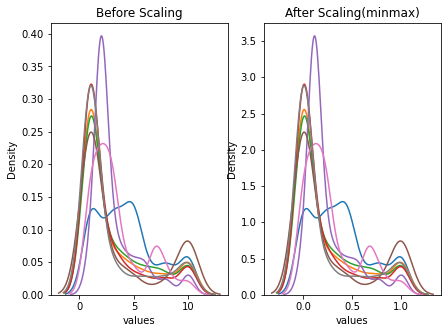

=========================== < Model name : DT_entropy > ===========================

Predict accuracy (using X_test, y_test)-->0.91429


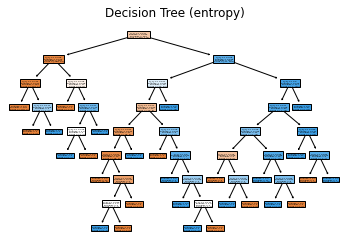

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=minmax , max_features=auto , CV=5): 0.9327954779033917
Average CV score(model=DT_entropy , scaler=minmax , max_features=auto , CV=7): 0.9342135642135643
Average CV score(model=DT_entropy , scaler=minmax , max_features=auto , CV=9): 0.9343064343064342

Predict accuracy (using X_test, y_test)-->0.91905


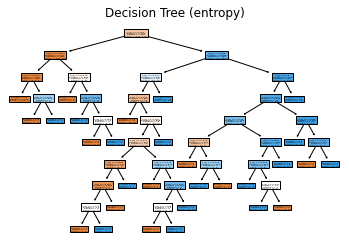

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=minmax , max_features=sqrt , CV=5): 0.9313669064748202
Average CV score(model=DT_entropy , scaler=minmax , max_features=sqrt , CV=7): 0.937085137085137
Average CV score(model=DT_entropy , scaler=minmax , max_features=sqrt , CV=9): 0.9385799385799385

Predict accuracy (using X_test, y_test)-->0.92381


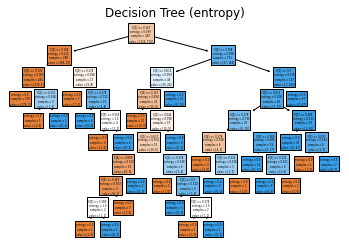

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=minmax , max_features=log2 , CV=5): 0.9313669064748202
Average CV score(model=DT_entropy , scaler=minmax , max_features=log2 , CV=7): 0.9342135642135643
Average CV score(model=DT_entropy , scaler=minmax , max_features=log2 , CV=9): 0.9400044400044398

=========================== < Model name : DT_gini > ===========================

Predict accuracy (using X_test, y_test)-->0.95238


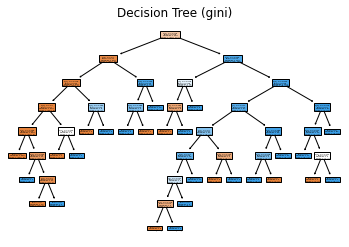

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=minmax , max_features=auto , CV=5): 0.9271017471736898
Average CV score(model=DT_gini , scaler=minmax , max_features=auto , CV=7): 0.9399422799422797
Average CV score(model=DT_gini , scaler=minmax , max_features=auto , CV=9): 0.9429274429274428

Predict accuracy (using X_test, y_test)-->0.96667


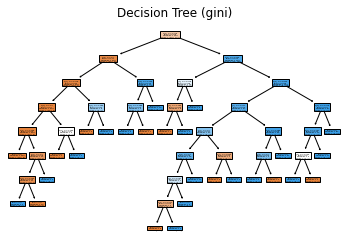

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=minmax , max_features=sqrt , CV=5): 0.9271017471736898
Average CV score(model=DT_gini , scaler=minmax , max_features=sqrt , CV=7): 0.9356709956709957
Average CV score(model=DT_gini , scaler=minmax , max_features=sqrt , CV=9): 0.9414474414474415

Predict accuracy (using X_test, y_test)-->0.96190


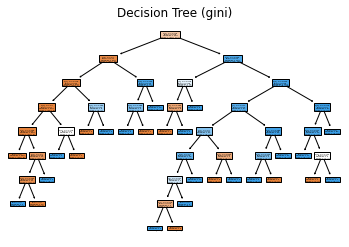

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=minmax , max_features=log2 , CV=5): 0.928540596094553
Average CV score(model=DT_gini , scaler=minmax , max_features=log2 , CV=7): 0.9385137085137084
Average CV score(model=DT_gini , scaler=minmax , max_features=log2 , CV=9): 0.9457579457579458

=========================== < Model name : SVM > ===========================

Predict accuracy (using X_test, y_test)-->0.95714
=========================== < Cross Validation > ===========================
Average CV score(model=SVM , scaler=minmax , kernel=linear , gamma=0.001 , C=0.01 , CV=5): 0.95
Average CV score(model=SVM , scaler=minmax , kernel=linear , gamma=0.001 , C=0.01 , CV=7): 0.9528571428571428
Average CV score(model=SVM , scaler=minmax , kernel=linear , gamma=0.001 , C=0.01 , CV=9): 0.9529729529729529

Predict accuracy (using X_test, y_test)-->0.96190
=========================== < Cross Validation > =================

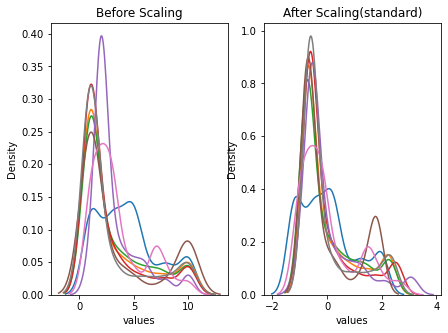

=========================== < Model name : DT_entropy > ===========================

Predict accuracy (using X_test, y_test)-->0.91905


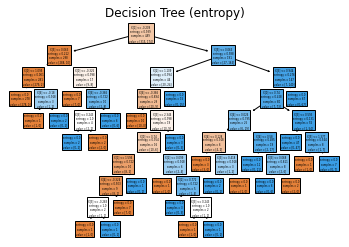

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=standard , max_features=auto , CV=5): 0.9384994861253855
Average CV score(model=DT_entropy , scaler=standard , max_features=auto , CV=7): 0.9356709956709957
Average CV score(model=DT_entropy , scaler=standard , max_features=auto , CV=9): 0.9386169386169385

Predict accuracy (using X_test, y_test)-->0.92381


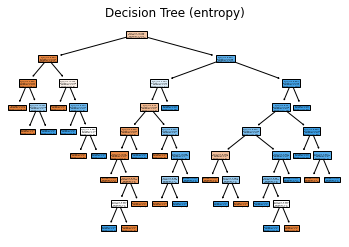

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=standard , max_features=sqrt , CV=5): 0.9342137718396712
Average CV score(model=DT_entropy , scaler=standard , max_features=sqrt , CV=7): 0.9313852813852813
Average CV score(model=DT_entropy , scaler=standard , max_features=sqrt , CV=9): 0.9414659414659413

Predict accuracy (using X_test, y_test)-->0.91429


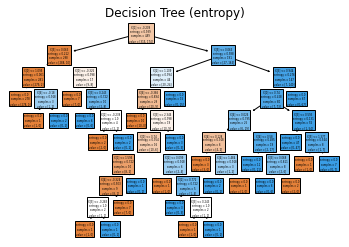

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=standard , max_features=log2 , CV=5): 0.9370811921891059
Average CV score(model=DT_entropy , scaler=standard , max_features=log2 , CV=7): 0.9356565656565656
Average CV score(model=DT_entropy , scaler=standard , max_features=log2 , CV=9): 0.9442779442779443

=========================== < Model name : DT_gini > ===========================

Predict accuracy (using X_test, y_test)-->0.95714


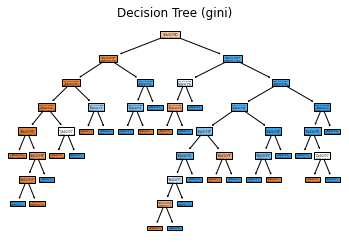

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=standard , max_features=auto , CV=5): 0.9271017471736898
Average CV score(model=DT_gini , scaler=standard , max_features=auto , CV=7): 0.9356421356421356
Average CV score(model=DT_gini , scaler=standard , max_features=auto , CV=9): 0.9443519443519443

Predict accuracy (using X_test, y_test)-->0.95238


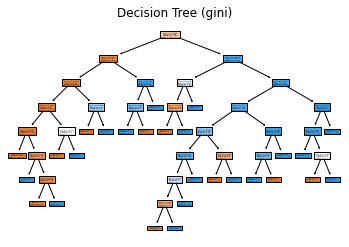

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=standard , max_features=sqrt , CV=5): 0.9256526207605346
Average CV score(model=DT_gini , scaler=standard , max_features=sqrt , CV=7): 0.9370995670995671
Average CV score(model=DT_gini , scaler=standard , max_features=sqrt , CV=9): 0.9385984385984385

Predict accuracy (using X_test, y_test)-->0.94762


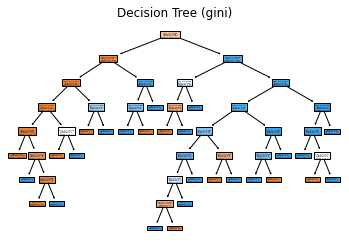

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=standard , max_features=log2 , CV=5): 0.9185200411099693
Average CV score(model=DT_gini , scaler=standard , max_features=log2 , CV=7): 0.9384992784992784
Average CV score(model=DT_gini , scaler=standard , max_features=log2 , CV=9): 0.937136937136937

=========================== < Model name : SVM > ===========================

Predict accuracy (using X_test, y_test)-->0.96667
=========================== < Cross Validation > ===========================
Average CV score(model=SVM , scaler=standard , kernel=linear , gamma=0.001 , C=0.01 , CV=5): 0.9628468653648511
Average CV score(model=SVM , scaler=standard , kernel=linear , gamma=0.001 , C=0.01 , CV=7): 0.9628427128427128
Average CV score(model=SVM , scaler=standard , kernel=linear , gamma=0.001 , C=0.01 , CV=9): 0.9629259629259628

Predict accuracy (using X_test, y_test)-->0.97143
=========================== < Cross Vali

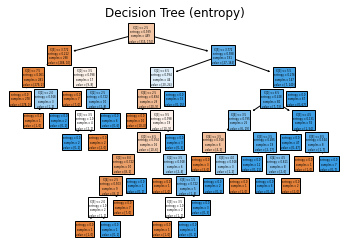

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=None , max_features=auto , CV=5): 0.929917780061665
Average CV score(model=DT_entropy , scaler=None , max_features=auto , CV=7): 0.9327849927849928
Average CV score(model=DT_entropy , scaler=None , max_features=auto , CV=9): 0.9428904428904428

Predict accuracy (using X_test, y_test)-->0.90952


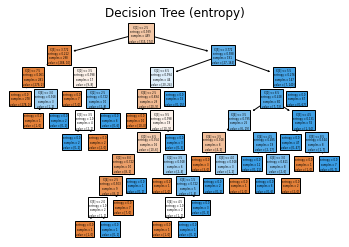

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=None , max_features=sqrt , CV=5): 0.9327749229188079
Average CV score(model=DT_entropy , scaler=None , max_features=sqrt , CV=7): 0.9284848484848485
Average CV score(model=DT_entropy , scaler=None , max_features=sqrt , CV=9): 0.9328819328819328

Predict accuracy (using X_test, y_test)-->0.91429


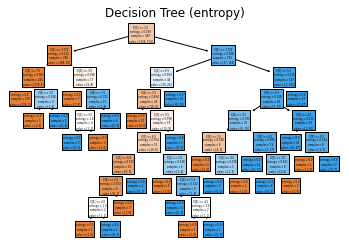

=========================== < Cross Validation > ===========================
Average CV score(model=DT_entropy , scaler=None , max_features=log2 , CV=5): 0.9370606372045222
Average CV score(model=DT_entropy , scaler=None , max_features=log2 , CV=7): 0.9327849927849928
Average CV score(model=DT_entropy , scaler=None , max_features=log2 , CV=9): 0.9400044400044398

=========================== < Model name : DT_gini > ===========================

Predict accuracy (using X_test, y_test)-->0.95714


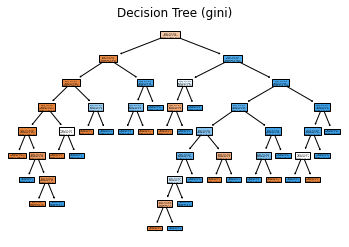

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=None , max_features=auto , CV=5): 0.9299691675231244
Average CV score(model=DT_gini , scaler=None , max_features=auto , CV=7): 0.9385425685425686
Average CV score(model=DT_gini , scaler=None , max_features=auto , CV=9): 0.9428534428534427

Predict accuracy (using X_test, y_test)-->0.95714


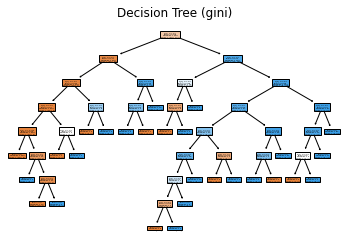

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=None , max_features=sqrt , CV=5): 0.9299588900308325
Average CV score(model=DT_gini , scaler=None , max_features=sqrt , CV=7): 0.9313564213564215
Average CV score(model=DT_gini , scaler=None , max_features=sqrt , CV=9): 0.9414659414659415

Predict accuracy (using X_test, y_test)-->0.95238


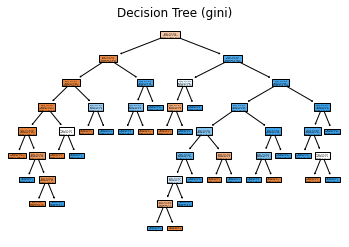

=========================== < Cross Validation > ===========================
Average CV score(model=DT_gini , scaler=None , max_features=log2 , CV=5): 0.9285303186022611
Average CV score(model=DT_gini , scaler=None , max_features=log2 , CV=7): 0.9342279942279942
Average CV score(model=DT_gini , scaler=None , max_features=log2 , CV=9): 0.937155437155437

=========================== < Model name : SVM > ===========================

Predict accuracy (using X_test, y_test)-->0.97143
=========================== < Cross Validation > ===========================
Average CV score(model=SVM , scaler=None , kernel=linear , gamma=0.001 , C=0.01 , CV=5): 0.9642857142857142
Average CV score(model=SVM , scaler=None , kernel=linear , gamma=0.001 , C=0.01 , CV=7): 0.9657142857142856
Average CV score(model=SVM , scaler=None , kernel=linear , gamma=0.001 , C=0.01 , CV=9): 0.9643504643504642

Predict accuracy (using X_test, y_test)-->0.96667
=========================== < Cross Validation > ===============

c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached 

Average CV score(model=logistic_regression , scaler=None , solver=sag , CV=9): 0.9615014615014614

Predict accuracy (using X_test, y_test)-->0.96190
=========================== < Cross Validation > ===========================
Average CV score(model=logistic_regression , scaler=None , solver=saga , CV=5): 0.962857142857143
Average CV score(model=logistic_regression , scaler=None , solver=saga , CV=7): 0.9614285714285715
Average CV score(model=logistic_regression , scaler=None , solver=saga , CV=9): 0.9615199615199614

< Top_5 >
['model=SVM , scaler=standard , kernel=sigmoid , gamma=1 , C=0.1 , CV=9', 0.972878972878973]
['model=SVM , scaler=standard , kernel=sigmoid , gamma=1 , C=0.1 , CV=7', 0.9728427128427127]
['model=SVM , scaler=standard , kernel=sigmoid , gamma=1 , C=0.1 , CV=5', 0.9699897225077081]
['model=SVM , scaler=standard , kernel=sigmoid , gamma=10 , C=0.1 , CV=5', 0.9699897225077081]
['model=SVM , scaler=standard , kernel=sigmoid , gamma=1 , C=0.01 , CV=5', 0.96856115107913

c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Cho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [50]:
# =====================================================================
# Main Code
# Describe whole process
# =====================================================================
# import libraries
# data exploration
# data preparation (drop unusable columns)
# data scaling (2 scaling methods, 1 original dataset used -> ['minmax','standard','None'])
    # modeling (4 models and each different parameters)
    # testing (kFold with k=[5,7,9])
    # Save model scores
# Print top 5 model scores
# =====================================================================

# Run the entire process and return top_5
top_5 = do_classification()

# Result top_5 mothod, parameters, scores
print('< Top_5 >')
for rank in top_5:
    print(rank)
